In [2]:
import numpy as np
import pandas as pd
import cv2
import tensorflow as tf
import keras
import keras.layers as layers
import sklearn
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import RepeatedKFold, train_test_split
from sklearn.metrics import confusion_matrix

2024-05-25 16:39:06.631394: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-25 16:39:07.228162: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [3]:
DataSolarModules = pd.read_json('InfraredSolarModules/module_metadata.json').transpose().sort_index()
Classes = DataSolarModules['anomaly_class'].unique()
class_to_number = dict(enumerate(Classes.flatten(), 0))
class_to_number = {v: k for k, v in class_to_number.items()}

In [4]:
def map_to_class(value):
    class_to_number
    return class_to_number.get(value, 'Unknown')

DataSolarModules['class_code'] = DataSolarModules['anomaly_class'].apply(map_to_class)

In [5]:
def read_images_dataframe(dataframe):
    images = []
    for image_path in dataframe['image_filepath']:
        img = cv2.imread("InfraredSolarModules/"+image_path,cv2.IMREAD_GRAYSCALE)
        img = img.reshape(40, 24).astype("float32") / 255
        images.append(img)
    images=np.array(images) 
    return images

def read_labels_dataframe(dataframe):
    labels = []
    for label in dataframe['class_code']:
        labels.append(label)
    labels=np.array(labels) 
    labels.astype("int32")   
    return labels

In [6]:
images = read_images_dataframe(DataSolarModules)
labels = read_labels_dataframe(DataSolarModules)


Unique values and their frequency:
anomaly_class
No-Anomaly        10000
Cell               1877
Vegetation         1639
Diode              1499
Cell-Multi         1288
Shadowing          1056
Cracking            940
Offline-Module      827
Hot-Spot            249
Hot-Spot-Multi      246
Soiling             204
Diode-Multi         175
Name: count, dtype: int64


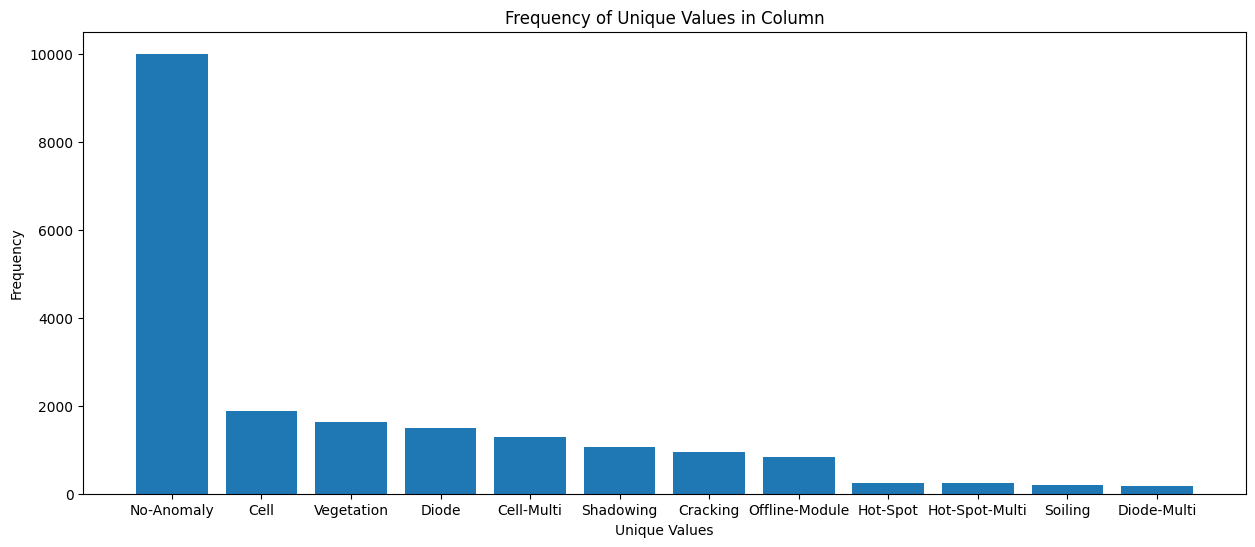

In [7]:
# Get unique values and their frequency
unique_values = DataSolarModules['anomaly_class'].value_counts()
print("\nUnique values and their frequency:")
print(unique_values)

# Set the figure size
plt.figure(figsize=(15, 6))

# Plot the bar chart
plt.bar(unique_values.index, unique_values.values)

# Set labels and title

plt.xlabel('Unique Values')
plt.ylabel('Frequency')
plt.title('Frequency of Unique Values in Column')

# Show the plot
plt.show()

In [8]:
# Create a testing set with 25 images per class
num_images_per_class = 40

def create_testing_set(dataframe, num_images_per_class):
    test_indices = []
    for cls in dataframe['class_code'].unique():
        class_indices = dataframe[dataframe['class_code'] == cls].index[:num_images_per_class].tolist()
        test_indices.extend(class_indices)
    return test_indices

test_indices = create_testing_set(DataSolarModules, num_images_per_class)
data_test = np.array(test_indices)
data_train = np.setdiff1d(np.arange(len(images)), data_test)

In [9]:
# Sample specified amount of images per class for training set
def sample_training_set(dataframe, samples):
    train_indices = []
    for cls, num_samples in enumerate(samples):
        class_indices = dataframe[dataframe['class_code'] == cls].index[num_images_per_class:]
        sampled_indices = class_indices[:num_samples].tolist()
        train_indices.extend(sampled_indices)
    return train_indices

#samples = [12, 21, 23, 23, 12, 43, 76, 54, 87, 23, 98, 12]
#train_indices = sample_training_set(DataSolarModules, samples)
#data_train = np.array(train_indices)


Unique values and their frequency in the training set:
anomaly_class
No-Anomaly        9960
Cell              1837
Vegetation        1599
Diode             1459
Cell-Multi        1248
Shadowing         1016
Cracking           900
Offline-Module     787
Hot-Spot           209
Hot-Spot-Multi     206
Soiling            164
Diode-Multi        135
Name: count, dtype: int64

Unique values and their frequency in the testing set:
anomaly_class
Offline-Module    40
Diode-Multi       40
Diode             40
Shadowing         40
Cell-Multi        40
Cell              40
Hot-Spot          40
Cracking          40
Hot-Spot-Multi    40
Soiling           40
Vegetation        40
No-Anomaly        40
Name: count, dtype: int64


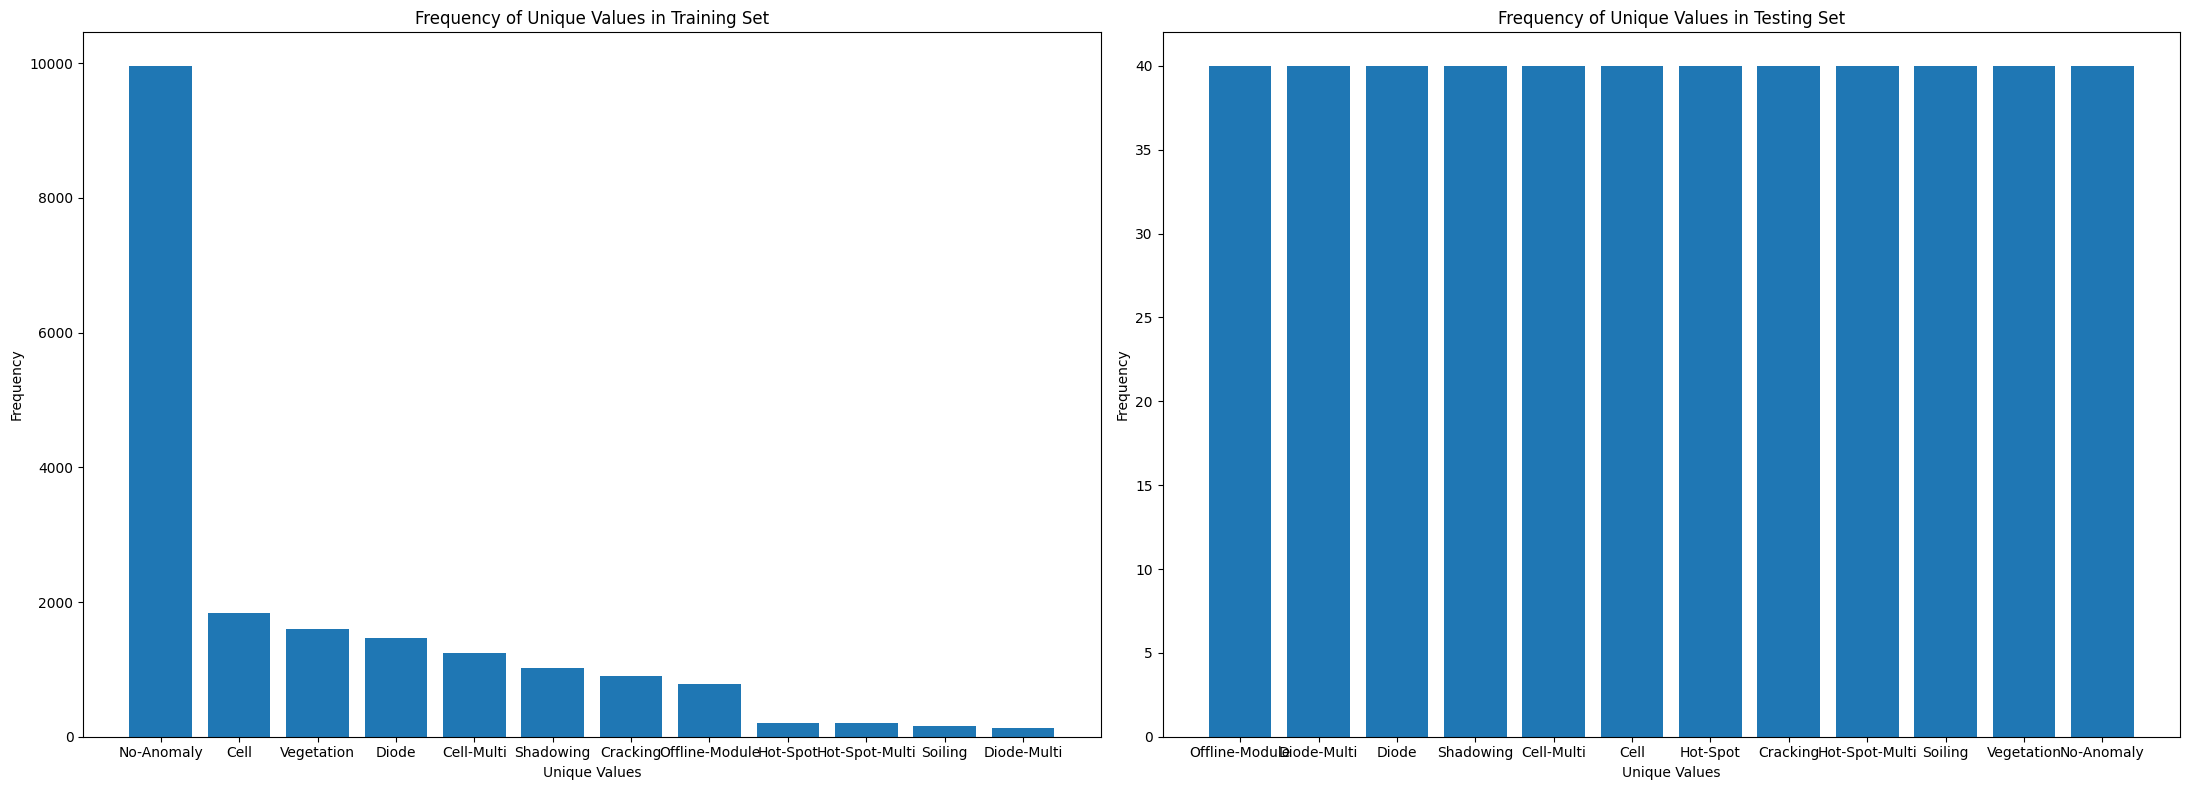

In [10]:
# Calculate unique values and their frequency in the training set
train_class_counts = DataSolarModules.iloc[data_train]['anomaly_class'].value_counts()
print("\nUnique values and their frequency in the training set:")
print(train_class_counts)

# Calculate unique values and their frequency in the testing set
test_class_counts = DataSolarModules.iloc[data_test]['anomaly_class'].value_counts()
print("\nUnique values and their frequency in the testing set:")
print(test_class_counts)

# Plot the bar chart for the training set
plt.figure(figsize=(22, 8))

plt.subplot(1, 2, 1)
plt.bar(train_class_counts.index, train_class_counts.values)
plt.xlabel('Unique Values')
plt.ylabel('Frequency')
plt.title('Frequency of Unique Values in Training Set')

# Plot the bar chart for the testing set
plt.subplot(1, 2, 2)
plt.bar(test_class_counts.index, test_class_counts.values)
plt.xlabel('Unique Values')
plt.ylabel('Frequency')
plt.title('Frequency of Unique Values in Testing Set')

# Show the plots
plt.tight_layout()
plt.show()

In [11]:
inputs = keras.Input(shape=(40, 24, 1))


x = layers.Conv2D(filters=16, kernel_size=3, activation="relu")(inputs)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)

x = layers.Flatten()(x)

x = layers.Dense(2048, activation="relu")(x)
x = layers.Dropout(0.4, noise_shape=None, seed=None)(x)
x = layers.Dense(1024, activation="relu")(x)
x = layers.Dropout(0.4, noise_shape=None, seed=None)(x)
x = layers.Dense(512, activation="relu")(x)
x = layers.Dropout(0.4, noise_shape=None, seed=None)(x)
x = layers.Dense(256, activation="relu")(x)
x = layers.Dropout(0.4, noise_shape=None, seed=None)(x)
x = layers.Dense(128, activation="relu")(x)


outputs = layers.Dense(12, activation="softmax")(x)
model = keras.Model(inputs=inputs, outputs=outputs)
model.summary()

2024-05-25 16:39:11.285971: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-05-25 16:39:11.319151: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-05-25 16:39:11.319394: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 40, 24, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 38, 22, 16)     │           160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 19, 11, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 17, 9, 32)      │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 8, 4, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 6, 2, 64)       │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 768)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 2048)           │     1,574,912 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1024)           │     2,098,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 512)            │       524,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 12)             │         1,548 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,386,956 (16.73 MB)

 Trainable params: 4,386,956 (16.73 MB)

 Non-trainable params: 0 (0.00 B)

In [12]:
batch_size = 64
n_epochs = 25

optimizer=tf.keras.optimizers.Adam(learning_rate=0.001)

rkf = RepeatedKFold(n_splits=6, n_repeats=3, random_state=21312312)
datos = list(range(0,len(images)))


model.compile(optimizer=optimizer,                                    
              loss="sparse_categorical_crossentropy",                 
              metrics=["accuracy"])   

In [13]:
fold_no = 1
acc_per_fold = []
loss_per_fold = []

all_train_losses = []
all_train_accuracies = []
all_val_losses = []
all_val_accuracies = []

for train, val in rkf.split(data_train):

    history_model = model.fit(images[train], labels[train],
                              epochs=n_epochs,
                              validation_data=(images[val], labels[val]),
                              batch_size=batch_size)

    # Store metrics for this fold
    fold_train_loss = np.mean(history_model.history['loss'])
    fold_train_accuracy = np.mean(history_model.history['accuracy'])
    fold_val_loss = np.mean(history_model.history['val_loss'])
    fold_val_accuracy = np.mean(history_model.history['val_accuracy'])

    all_train_losses.append(fold_train_loss)
    all_train_accuracies.append(fold_train_accuracy)
    all_val_losses.append(fold_val_loss)
    all_val_accuracies.append(fold_val_accuracy)

    # Generate generalization metrics for the last epoch
    scores = model.evaluate(images[val], labels[val],verbose=0)
    print(f'Score for fold {fold_no}: {model.metrics_names[0]} of {scores[0]}; {model.metrics_names[1]} of {scores[1] * 100}%')
    acc_per_fold.append(scores[1] * 100)
    loss_per_fold.append(scores[0])

    # Increase fold number
    fold_no += 1

Epoch 1/25


I0000 00:00:1716626352.871598  205203 service.cc:145] XLA service 0x7058a8014000 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1716626352.871620  205203 service.cc:153]   StreamExecutor device (0): NVIDIA GeForce RTX 3080 Ti, Compute Capability 8.6
2024-05-25 16:39:12.906706: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-05-25 16:39:13.088058: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:465] Loaded cuDNN version 8907


107/255 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.4628 - loss: 2.0473

I0000 00:00:1716626357.381955  205203 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


255/255 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.4760 - loss: 1.9472

I0000 00:00:1716626364.492987  205414 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_89', 308 bytes spill stores, 308 bytes spill loads

I0000 00:00:1716626364.544635  205407 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_82', 192 bytes spill stores, 192 bytes spill loads

I0000 00:00:1716626364.567827  205411 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_89', 192 bytes spill stores, 192 bytes spill loads

I0000 00:00:1716626366.304929  205523 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_96', 4 bytes spill stores, 4 bytes spill loads

I0000 00:00:1716626366.610932  205526 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_82', 4 bytes spill stores, 4 bytes spill loads

I0000 00:00:1716626367.254670  205527 

255/255 ━━━━━━━━━━━━━━━━━━━━ 17s 43ms/step - accuracy: 0.4761 - loss: 1.9469 - val_accuracy: 0.4852 - val_loss: 1.7603
Epoch 2/25
255/255 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.4871 - loss: 1.7807 - val_accuracy: 0.4852 - val_loss: 1.7246
Epoch 3/25
255/255 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.4914 - loss: 1.7323 - val_accuracy: 0.4862 - val_loss: 1.7080
Epoch 4/25
255/255 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.4962 - loss: 1.6888 - val_accuracy: 0.5338 - val_loss: 1.5341
Epoch 5/25
255/255 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.5346 - loss: 1.5557 - val_accuracy: 0.5691 - val_loss: 1.4542
Epoch 6/25
255/255 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5657 - loss: 1.4666 - val_accuracy: 0.6063 - val_loss: 1.3180
Epoch 7/25
255/255 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5941 - loss: 1.3652 - val_accuracy: 0.6223 - val_loss: 1.2303
Epoch 8/25
255/255 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6099 - loss: 1.3113 - val_accuracy: 0.6220 - va

I0000 00:00:1716626378.471366  207034 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_89', 192 bytes spill stores, 192 bytes spill loads

I0000 00:00:1716626379.041703  207038 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_82', 16 bytes spill stores, 16 bytes spill loads

I0000 00:00:1716626379.180965  207028 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_82', 192 bytes spill stores, 192 bytes spill loads

I0000 00:00:1716626380.596859  207164 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_82', 264 bytes spill stores, 264 bytes spill loads

I0000 00:00:1716626380.917038  207157 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_89', 260 bytes spill stores, 260 bytes spill loads



Score for fold 1: loss of 0.9049580693244934; compile_metrics of 72.12661504745483%
Epoch 1/25
255/255 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7176 - loss: 0.8992 - val_accuracy: 0.7514 - val_loss: 0.7696
Epoch 2/25
255/255 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7250 - loss: 0.8596 - val_accuracy: 0.7415 - val_loss: 0.8008
Epoch 3/25
255/255 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7211 - loss: 0.8601 - val_accuracy: 0.7419 - val_loss: 0.7944
Epoch 4/25
255/255 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7341 - loss: 0.8361 - val_accuracy: 0.7538 - val_loss: 0.7705
Epoch 5/25
255/255 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7424 - loss: 0.8104 - val_accuracy: 0.7502 - val_loss: 0.7806
Epoch 6/25
255/255 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7349 - loss: 0.8186 - val_accuracy: 0.7440 - val_loss: 0.7694
Epoch 7/25
255/255 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7400 - loss: 0.7835 - val_accuracy: 0.7529 - val_loss: 0.7722
Epoch 8/25
255/255 ━

I0000 00:00:1716626400.780383  208876 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_82', 4 bytes spill stores, 4 bytes spill loads

I0000 00:00:1716626400.923153  208864 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_82', 264 bytes spill stores, 264 bytes spill loads

I0000 00:00:1716626400.928589  208871 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_89', 336 bytes spill stores, 344 bytes spill loads

I0000 00:00:1716626401.112709  208859 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_96', 4 bytes spill stores, 4 bytes spill loads

I0000 00:00:1716626401.327832  208876 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_89', 260 bytes spill stores, 260 bytes spill loads

I0000 00:00:1716626401.369536  208863 

255/255 ━━━━━━━━━━━━━━━━━━━━ 10s 40ms/step - accuracy: 0.7953 - loss: 0.6329 - val_accuracy: 0.8380 - val_loss: 0.4895
Epoch 2/25
255/255 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7986 - loss: 0.6156 - val_accuracy: 0.8300 - val_loss: 0.4983
Epoch 3/25
255/255 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7964 - loss: 0.6089 - val_accuracy: 0.8269 - val_loss: 0.4991
Epoch 4/25
255/255 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7981 - loss: 0.6018 - val_accuracy: 0.8300 - val_loss: 0.4912
Epoch 5/25
255/255 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8073 - loss: 0.5673 - val_accuracy: 0.8211 - val_loss: 0.5321
Epoch 6/25
255/255 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8130 - loss: 0.5615 - val_accuracy: 0.8346 - val_loss: 0.4993
Epoch 7/25
255/255 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8069 - loss: 0.5791 - val_accuracy: 0.8205 - val_loss: 0.5258
Epoch 8/25
255/255 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8097 - loss: 0.5615 - val_accuracy: 0.8251 - va

I0000 00:00:1716626412.999174  210366 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_89', 260 bytes spill stores, 260 bytes spill loads

I0000 00:00:1716626413.100420  210368 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_82', 264 bytes spill stores, 264 bytes spill loads



Score for fold 3: loss of 0.6169094443321228; compile_metrics of 80.78696727752686%
Epoch 1/25
255/255 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8380 - loss: 0.5156 - val_accuracy: 0.9035 - val_loss: 0.3239
Epoch 2/25
255/255 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8400 - loss: 0.4767 - val_accuracy: 0.8943 - val_loss: 0.3139
Epoch 3/25
255/255 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8463 - loss: 0.4648 - val_accuracy: 0.8792 - val_loss: 0.3595
Epoch 4/25
255/255 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8431 - loss: 0.4741 - val_accuracy: 0.8992 - val_loss: 0.3185
Epoch 5/25
255/255 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8445 - loss: 0.4676 - val_accuracy: 0.8887 - val_loss: 0.3220
Epoch 6/25
255/255 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8525 - loss: 0.4481 - val_accuracy: 0.8872 - val_loss: 0.3402
Epoch 7/25
255/255 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8561 - loss: 0.4293 - val_accuracy: 0.8813 - val_loss: 0.3486
Epoch 8/25
255/255 ━

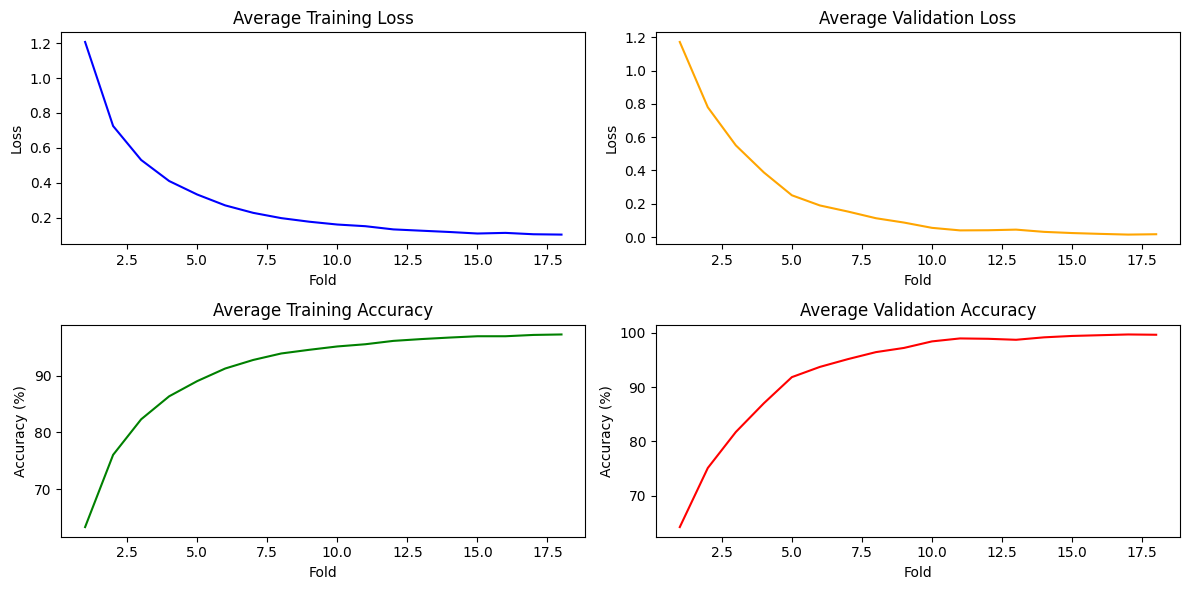

In [14]:
plt.figure(figsize=(12, 6))

plt.subplot(2, 2, 1)
plt.plot(range(1, len(all_train_losses) + 1), all_train_losses, color='blue')
plt.title('Average Training Loss')
plt.xlabel('Fold')
plt.ylabel('Loss')

plt.subplot(2, 2, 2)
plt.plot(range(1, len(all_val_losses) + 1), all_val_losses, color='orange')
plt.title('Average Validation Loss')
plt.xlabel('Fold')
plt.ylabel('Loss')

plt.subplot(2, 2, 3)
plt.plot(range(1, len(all_train_accuracies) + 1), [acc * 100 for acc in all_train_accuracies], color='green')
plt.title('Average Training Accuracy')
plt.xlabel('Fold')
plt.ylabel('Accuracy (%)')

plt.subplot(2, 2, 4)
plt.plot(range(1, len(all_val_accuracies) + 1), [acc * 100 for acc in all_val_accuracies], color='red')
plt.title('Average Validation Accuracy')
plt.xlabel('Fold')
plt.ylabel('Accuracy (%)')

plt.tight_layout()
plt.show()

In [15]:
test_metrics = model.evaluate(images[data_test], labels[data_test])  
print("Test loss:", test_metrics[0])
print("Test accuracy:", test_metrics[1])

15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 759us/step - accuracy: 1.0000 - loss: 0.0066
Test loss: 0.007626802194863558
Test accuracy: 1.0


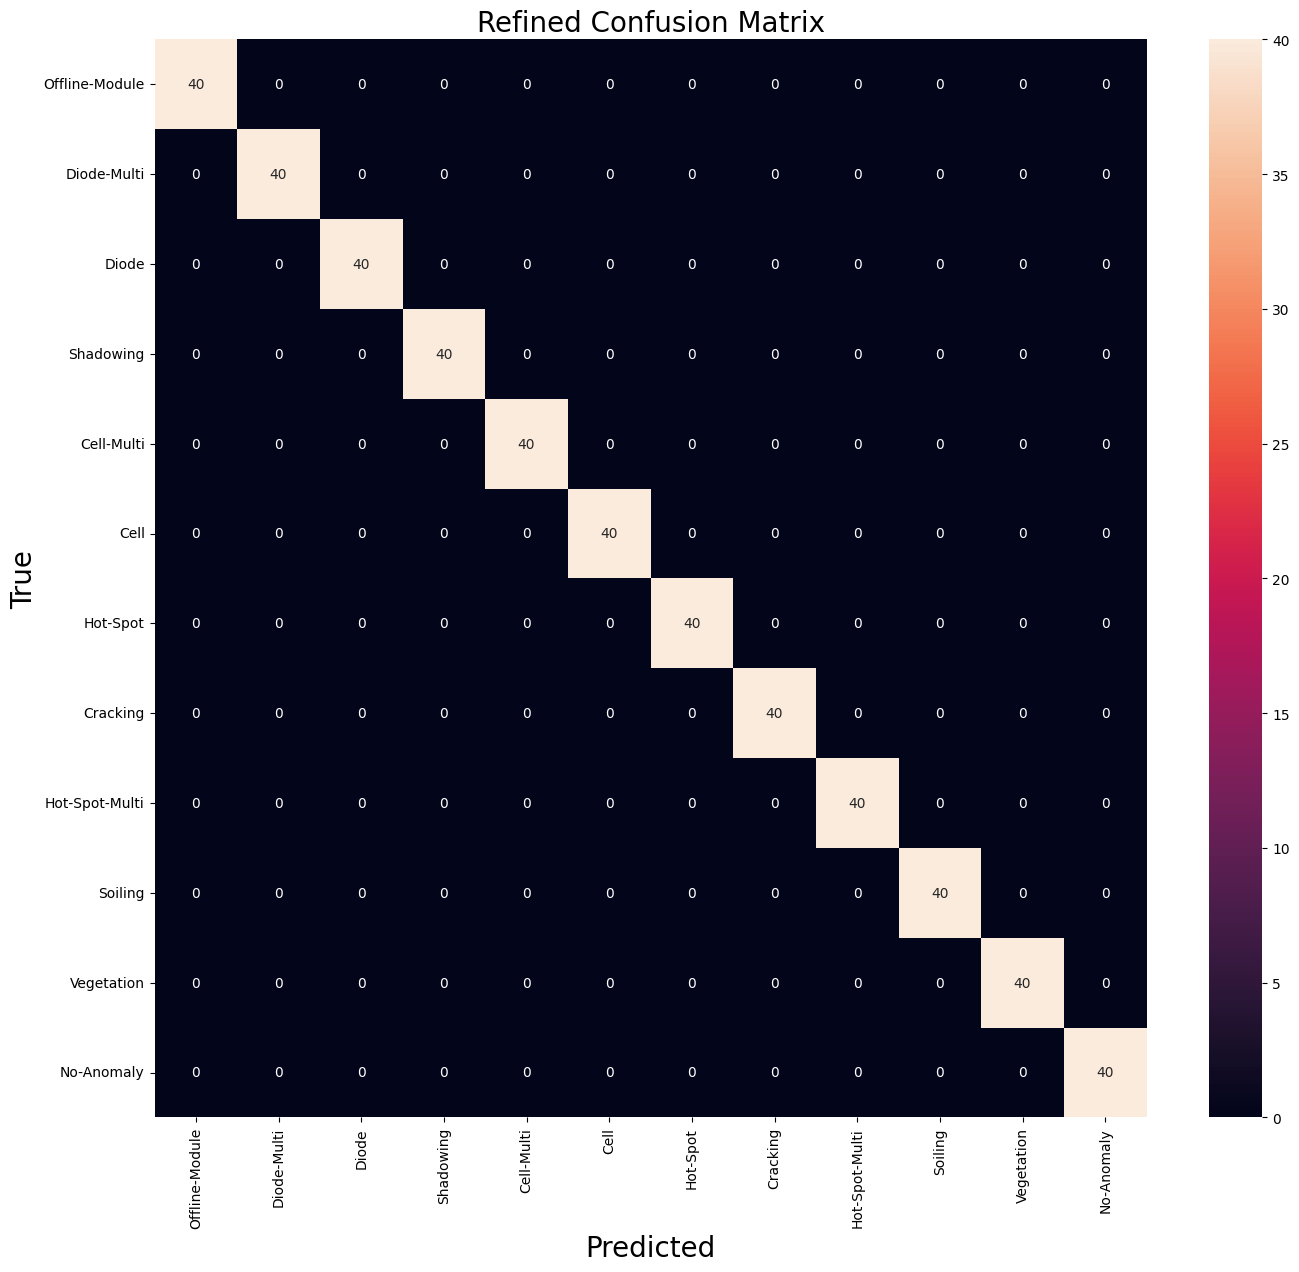

In [16]:
### Confusion Matrix
predictions = model.predict(images[data_test], steps=len(data_test), verbose=0)

y_pred = np.argmax(predictions, axis=-1)

cm = confusion_matrix(labels[data_test], y_pred)

## Get Class Labels
class_names = Classes

# Plot confusion matrix in a beautiful manner
fig = plt.figure(figsize=(16, 14))
ax= plt.subplot()
sns.heatmap(cm, annot=True,robust=True, ax = ax, fmt = 'g'); #annot=True to annotate cells
# labels, title and ticks
ax.set_xlabel('Predicted', fontsize=20)
ax.xaxis.set_label_position('bottom')
plt.xticks(rotation=90)
ax.xaxis.set_ticklabels(class_names, fontsize = 10)
ax.xaxis.tick_bottom()

ax.set_ylabel('True', fontsize=20)
ax.yaxis.set_ticklabels(class_names, fontsize = 10)
plt.yticks(rotation=0)

plt.title('Refined Confusion Matrix', fontsize=20)

plt.show()

In [17]:
tp_and_fn = cm.sum(1)
tp_and_fp = cm.sum(0)
tp = cm.diagonal()
accuracy = cm.diagonal().sum()/cm.sum()
precision = tp / tp_and_fp
recall = tp / tp_and_fn
f1 = 2 * (precision * recall) / (precision + recall)
precision_avg=np.average(precision)
recall_avg=np.average(recall)
f1_avg=np.average(f1)

In [18]:
# Creating a dictionary with the data
data = {
    'Metrics': ['Accuracy', 'Average Precision', 'Average Recall', 'Average F1 Score'],
    'Values': [accuracy, precision_avg, recall_avg, f1_avg]
}

# Creating the DataFrame
df = pd.DataFrame(data)

# Displaying the DataFrame
print(df)

             Metrics  Values
0           Accuracy     1.0
1  Average Precision     1.0
2     Average Recall     1.0
3   Average F1 Score     1.0


In [19]:
data = {
    'Class': class_names,
    'Precision': precision,
    'Recall': recall,
    'F1 Score': f1
}

# Creating the DataFrame
df = pd.DataFrame(data)

# Displaying the DataFrame
print(df)

             Class  Precision  Recall  F1 Score
0   Offline-Module        1.0     1.0       1.0
1      Diode-Multi        1.0     1.0       1.0
2            Diode        1.0     1.0       1.0
3        Shadowing        1.0     1.0       1.0
4       Cell-Multi        1.0     1.0       1.0
5             Cell        1.0     1.0       1.0
6         Hot-Spot        1.0     1.0       1.0
7         Cracking        1.0     1.0       1.0
8   Hot-Spot-Multi        1.0     1.0       1.0
9          Soiling        1.0     1.0       1.0
10      Vegetation        1.0     1.0       1.0
11      No-Anomaly        1.0     1.0       1.0
